chow test 이외의 방법을 적용하여서 비교보아도 GPT전/후의 차이를 보이는지 확인 

t-test와 mann-whitney방법 적용 

5/10/15/20/25/30 일 기준 질문을 30개씩 샘플링 X 10번 반복  
각 버전 별로 난이도 비율 계산하여 chow test 수행 

In [1]:
import sys, os
p = os.path.abspath('..')
pp = os.path.abspath('../..')
sys.path.insert(1, p)
sys.path.insert(1, pp)

In [2]:
import config.config as conf
import pickle
from scipy.stats import levene, ttest_ind
import datetime 
import numpy as np
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import scipy.stats as stats
import seaborn as sns
import lib.annotation.Result_Prep as rp

1.3 독립표본 t-검정 (paired sample t-test)¶  
 
두개의 독립된 모집단의 평균을 비교하고자 할 때 사용하는 검정
두 개의 모집단에서 크기가 n개인 표본을 각각 추출한 후 표본의 관측값들을 이용해 검정을 실시. 따라서 독립표본 t검정에서는 모집단, 모수, 표본이 모두 두개씩 존재.
두 모집단은 정규성을 만족해야한다. 표본의 크기가 충분히 크다면 중심극한정리에 따라 정규성을 만족한다고 볼 수 있다. / 두개의 모집단은 서로 독립적이어야 한다. / 두 모집단의 분산이 서로 같음을 의미하는 등분산성 가정을 만족해야한다 (등분산성 가정은 두 독립집단의 모분산이 동일해야함을 의미)/ 독립변수는 범주형, 종속변수는 연속형이어야 한다.
부부100쌍을 뽑아 남편 100명과 아내 100명으로 집단 비교하는 경우는 대응표본/ 무작위로 남자 100명 여자 100명을 뽑아 두 집단을 비교하는 경우는 독립표본

In [3]:
with open(f'{conf.DATA_PATH}/data/m_chk_cnt_0.pkl', 'rb') as f:
    m_chk_cnt_0 = pickle.load(f)

In [4]:
with open(f'{conf.DATA_PATH}/data/m_chk_cnt_1.pkl', 'rb') as f:
    m_chk_cnt_1 = pickle.load(f)

In [5]:
with open(f'{conf.DATA_PATH}/data/m_chk_cnt_2.pkl', 'rb') as f:
    m_chk_cnt_2 = pickle.load(f)

In [6]:
path = f'../LLM/result'
file_list = os.listdir(path)

In [7]:
r_p = rp.Result_Prep()

정규성 확인

In [8]:
b_p = stats.shapiro(m_chk_cnt_0['rate']).pvalue
i_p = stats.shapiro(m_chk_cnt_1['rate']).pvalue
a_p = stats.shapiro(m_chk_cnt_2['rate']).pvalue

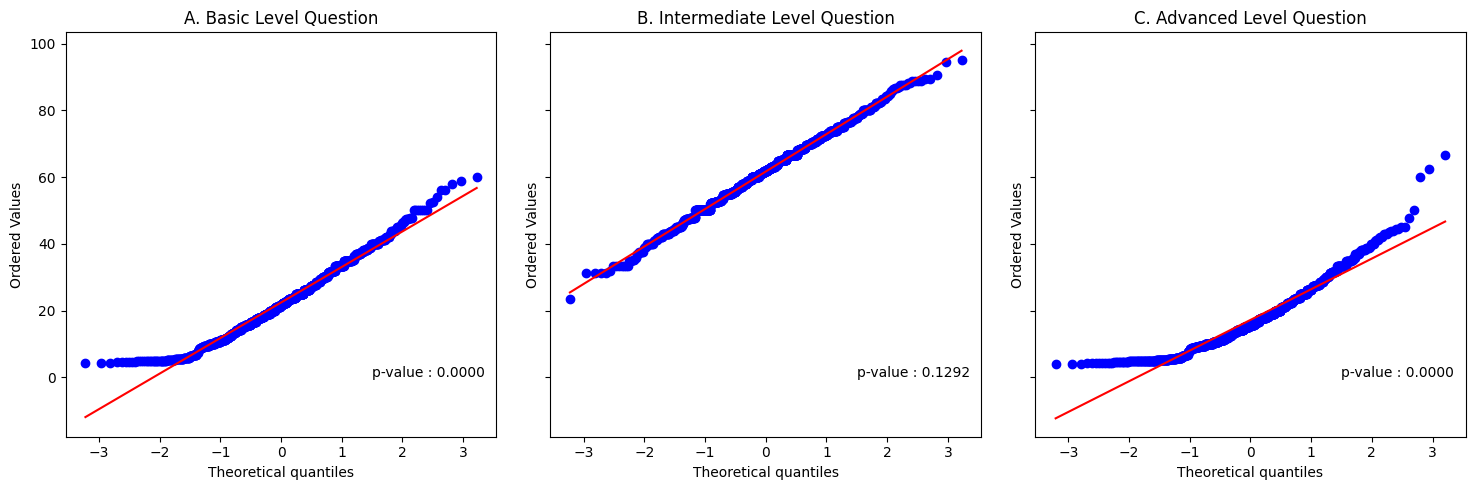

In [9]:
### create a figure with multiple subplots
sharey = True ## 또는 sharey=False
sharex = True ## 또는 sharex=False

fig, axs = plt.subplots(1, 3, figsize = (15, 5), sharey=sharey, sharex=sharex)


stats.probplot(m_chk_cnt_0['rate'], plot=axs[0])
axs[0].set_title(f"A. Basic Level Question")
axs[0].text(1.5, 0, s=f'p-value : {b_p:.4f}', fontsize = 10) #


stats.probplot(m_chk_cnt_1['rate'], plot=axs[1])
axs[1].set_title(f"B. Intermediate Level Question")
axs[1].text(1.5, 0, s=f'p-value : {i_p:.4f}', fontsize = 10) #

stats.probplot(m_chk_cnt_2['rate'], plot=axs[2])
axs[2].set_title(f"C. Advanced Level Question")
axs[2].text(1.5, 0, s=f'p-value : {a_p:.4f}', fontsize = 10) #

fig.tight_layout()
plt.show();

fig.savefig("normalityFordiff_ver3.png", dpi=300, bbox_inches='tight')  # DPI 설정 및 여백 최소화

In [10]:
def ttest_simulation(df, iv, max_diff_day):
    return_df = pd.DataFrame()

    for i in range(30, 30+max_diff_day):
        af_df = df[(df['rel_days']>=0) & (df['rel_days'] <0+i)  ]
        bf_df = df[(df['rel_days'] <0) & (df['rel_days']>=0-i)  ]

        if levene(bf_df[iv],af_df[iv]).pvalue >=0.05 :
            pvalue = ttest_ind(bf_df[iv],af_df[iv], equal_var=False).pvalue
        else : 
            pvalue = ttest_ind(bf_df[iv],af_df[iv]).pvalue

        n_rows = pd.DataFrame({'diff_day': [i], 'pvalue': [float(f'{pvalue:0.4f}')]})
        return_df = pd.concat([return_df, n_rows], axis = 0).reset_index(drop=True)

    return return_df


In [11]:
def mann_simulation(df, iv, max_diff_day):
    return_df = pd.DataFrame()

    for i in range(30, 30+max_diff_day):
        af_df = df[(df['rel_days']>=0) & (df['rel_days'] <0+i)  ]
        bf_df = df[(df['rel_days'] <0) & (df['rel_days']>=0-i)  ]

        stat, p = mannwhitneyu(af_df[iv], bf_df[iv])

        n_rows = pd.DataFrame({'diff_day': [i], 'pvalue': [float(f'{p:0.4f}')]})
        return_df = pd.concat([return_df, n_rows], axis = 0).reset_index(drop=True)

    return return_df


In [12]:
m_chk_cnt_0_p_tdf = ttest_simulation(m_chk_cnt_0,    'rate',     270)
m_chk_cnt_1_p_tdf = ttest_simulation(m_chk_cnt_1,    'rate',     270)
m_chk_cnt_2_p_tdf = ttest_simulation(m_chk_cnt_2,    'rate',     270)


m_chk_cnt_0_p_mdf = mann_simulation(m_chk_cnt_0,    'rate',     270)
m_chk_cnt_1_p_mdf = mann_simulation(m_chk_cnt_1,    'rate',     270)
m_chk_cnt_2_p_mdf = mann_simulation(m_chk_cnt_2,    'rate',     270)


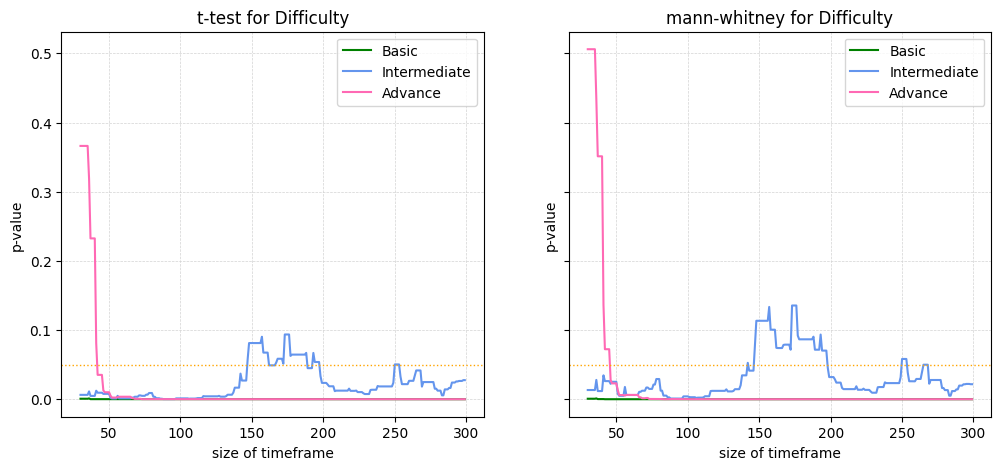

In [13]:
### create a figure with multiple subplots
sharey = True ## 또는 sharey=False
sharex = True ## 또는 sharex=False

fig, axs = plt.subplots(1, 2, figsize = (12, 5), sharey=sharey, sharex=sharex)


axs[0].plot(m_chk_cnt_0_p_tdf['diff_day'], m_chk_cnt_0_p_tdf['pvalue'], label="Basic", color="green") 
axs[0].plot(m_chk_cnt_1_p_tdf['diff_day'], m_chk_cnt_1_p_tdf['pvalue'], label="Intermediate", color="CornflowerBlue")  
axs[0].plot(m_chk_cnt_2_p_tdf['diff_day'], m_chk_cnt_2_p_tdf['pvalue'], label="Advance", color="hotpink")  
axs[0].set_xlabel('size of timeframe')
axs[0].set_ylabel('p-value')
axs[0].axhline(0.05, color='orange', linestyle=':', linewidth=1)
# axs[0].axvline(50, color='red', linestyle='--', linewidth=1)
axs[0].set_title('t-test for Difficulty')
axs[0].grid(color='lightgray', linestyle = '--', linewidth = 0.5)
axs[0].legend()

axs[1].plot(m_chk_cnt_0_p_mdf['diff_day'], m_chk_cnt_0_p_mdf['pvalue'], label="Basic", color="green") 
axs[1].plot(m_chk_cnt_1_p_mdf['diff_day'], m_chk_cnt_1_p_mdf['pvalue'], label="Intermediate", color="CornflowerBlue")  
axs[1].plot(m_chk_cnt_2_p_mdf['diff_day'], m_chk_cnt_2_p_mdf['pvalue'], label="Advance", color="hotpink")
axs[1].set_xlabel('size of timeframe')
axs[1].set_ylabel('p-value')
axs[1].axhline(0.05, color='orange', linestyle=':', linewidth=1)
# axs[1].axvline(50, color='red', linestyle='--', linewidth=1)
axs[1].set_title('mann-whitney for Difficulty')
axs[1].grid(color='lightgray', linestyle = '--', linewidth = 0.5)
axs[1].legend()

plt.show();

fig.savefig("d_tm_ver3.png", dpi=300, bbox_inches='tight')  # DPI 설정 및 여백 최소화

In [14]:
from scipy.stats import mannwhitneyu

def errorbar_pp(df, std_date, iv):
    af_df = df[(df['rel_days']>=0) & (df['rel_days'] <0+std_date)  ]
    bf_df = df[(df['rel_days'] <0) & (df['rel_days']>=0-std_date)  ]

    
    means = [np.mean(bf_df[iv]), np.mean(af_df[iv])]  # 그룹 평균
    std_devs = [bf_df[iv].std(), af_df[iv].std()]  # 그룹 표준편차 (또는 표준오차)
    stat, p = mannwhitneyu(bf_df[iv], af_df[iv])

    return means, std_devs, stat, p



In [15]:
means_0, std_devs_0, stat_0, p_0  = errorbar_pp(m_chk_cnt_0, 150, 'rate')
means_1, std_devs_1, stat_1, p_1  = errorbar_pp(m_chk_cnt_1, 150, 'rate')
means_2, std_devs_2, stat_2, p_2  = errorbar_pp(m_chk_cnt_2, 150, 'rate')

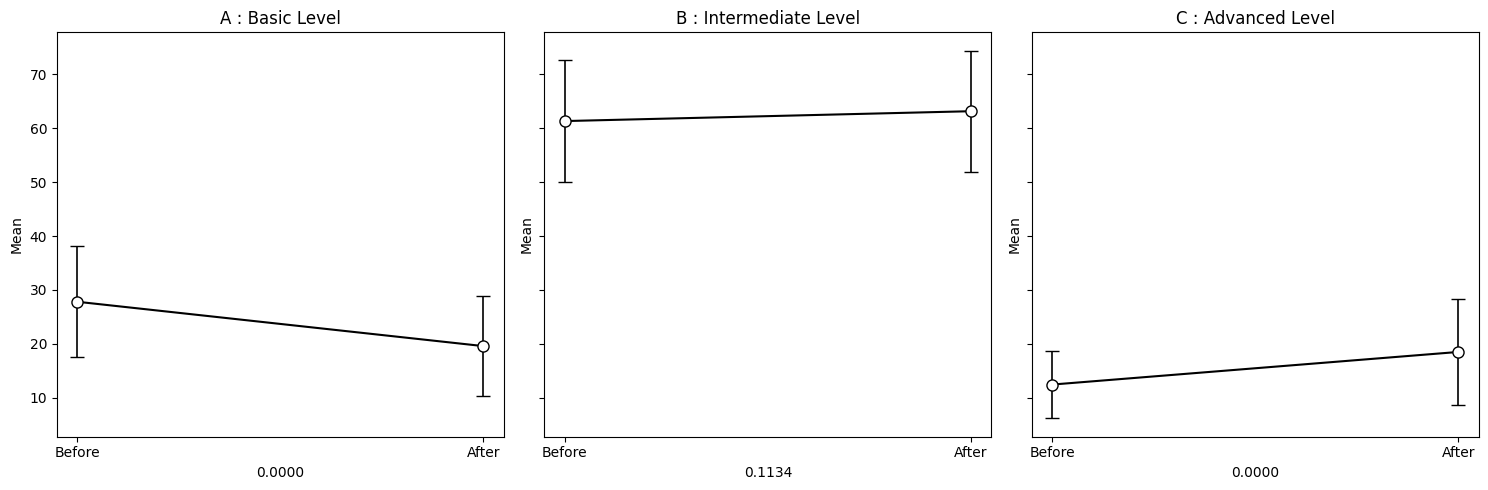

In [16]:
groups = ['Before', 'After']

sharey = True ## 또는 sharey=False
sharex = True ## 또는 sharex=False

fig, axs = plt.subplots(1, 3, figsize = (15, 5), sharey=sharey, sharex=sharex)


axs[0].errorbar(groups, means_0, yerr=std_devs_0, fmt='o-', color='black', ecolor='black', capsize=5, elinewidth=1.2, markerfacecolor='white', markersize=8)
axs[0].set_xlabel(f'{p_0:0.4f}')
axs[0].set_ylabel('Mean')
axs[0].set_title(f'A : Basic Level')

axs[1].errorbar(groups, means_1, yerr=std_devs_1, fmt='o-', color='black', ecolor='black', capsize=5, elinewidth=1.2, markerfacecolor='white', markersize=8)
axs[1].set_xlabel(f'{p_1:0.4f}')
axs[1].set_ylabel('Mean')
axs[1].set_title('B : Intermediate Level')

axs[2].errorbar(groups, means_2, yerr=std_devs_2, fmt='o-', color='black', ecolor='black', capsize=5, elinewidth=1.2, markerfacecolor='white', markersize=8)
axs[2].set_xlabel(f'{p_2:0.4f}')
axs[2].set_ylabel('Mean')
axs[2].set_title('C : Advanced Level')
fig.tight_layout()
plt.show();

fig.savefig("mean_std_diff_ver3.png", dpi=300, bbox_inches='tight')  # DPI 설정 및 여백 최소화
